# Fig 6

Fix variance, let mean vary

- A) As host mean varies, how many years for yield to reach X for sprays = 1, 2, 3

- B) Same but for point distribution with no host mutation (host doesn't degrade)

- C) Fungicide distribution mean after years = e.g. 10 for sprays = 1, 2, 3

- D) Host distribution mean after years = e.g. 10 for sprays = 1, 2, 3

So need dataframe with columns:

- sprays
- host mean start
- year 1...N yield
- year 0...N fung mean
- year 0...N host mean

Then each model run is a single row.

Have one df for variance non zero and one for point distribution/no mutation

- A: need new column - year in which yield < X
- B: same as A but for point dist
- C: host mean start vs host_mean_year_10
- D: host_mean_start vs fung_mean_year_10

Use cluster - single run per host mean start value for 1,2,3 sprays

Relies on `cluster/fig6_mutual.py` which is called via `cluster/fig6_mutual.submit`. This generates data which is combined via `cluster/mutual_pp.py`.

Similarly for `fig6_replacement_mutual.py`, submit etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from math import floor

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from plotly import colors

sns.set_theme(style="ticks")

from colour import Color
import itertools

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from math import exp, log, log10

from polymodel.config import Config

# from polymodel.run import (
#     multiple_run,
#     simulations_run,
# )

from polymodel.utils import (
    Fungicide,
    find_beta_vectorised,
    truncated_exp_pdf,
    logit10_vectorised,
    initial_point_distribution,
    trait_vec
)

from polymodel.consts import (
    DEFAULT_I0, 
    DEFAULT_BETA,
    MUTATION_PROP,
    FUNG_MUTATION_SCALE,
    HOST_MUTATION_SCALE,
    DEFAULT_P,
    TRAIN_TEST_SPLIT_PROPORTION
)

from plots.fns import (
    dist_means_as_df, 
    # generate_dist_mean,
    # generate_dist_var,
    # generate_dists,
    # get_dist_traces,
    get_arrow_annotation,
    get_text_annotation,
    standard_layout,
    traces_with_uncertainty,
    traces_with_uncertainty_bands, 
    hex_to_rgb
)

In [3]:
COLZ = sns.color_palette('muted').as_hex()

## varying host efficacy

In [4]:
def years_above_threshold(df, thresh=10, name='over_th'):
    
    mod = (
        pd.DataFrame(
        df
        .filter(like='yld')
        .T
        )
        .assign(over_th = lambda x: x>thresh)
        .loc[:, ['over_th']]
        .rename(columns={'over_th': name})
    )
    
    return mod.sum()

In [8]:
dfn = pd.read_csv('../data/05_outputs/fig6/fig_6_theoretical.csv').iloc[:, 2:]

eps = 0.15

dfn_use = (
    dfn
    .apply(lambda df: years_above_threshold(df, 10.1, 'over_th1'), axis=1)
    .join(dfn)
    .join(
        dfn
        .apply(lambda df: years_above_threshold(df, 9.5, 'over_th2'), axis=1)
        .join(dfn)
        .loc[:, ['over_th2']]
    )
    .assign(over_th_use = lambda df: df.over_th1 + eps*(4-df.sprays) - 2*eps)
)

dfn_use

,over_th1,host_mean_start,sprays,yld1,yld2,yld3,yld4,yld5,yld6,yld7,...,host_mean43,host_mean44,host_mean45,host_mean46,host_mean47,host_mean48,host_mean49,host_mean50,over_th2,over_th_use
0,15,0.01,1,10.567714,10.567292,10.562293,10.531260,10.495861,10.468658,10.445024,...,0.991450,0.991856,0.992211,0.992520,0.992791,0.993028,0.993236,0.993419,26,15.15
1,15,0.01,2,10.567777,10.567687,10.567301,10.565298,10.558759,10.551149,10.545231,...,0.990314,0.990867,0.991349,0.991769,0.992135,0.992455,0.992734,0.992978,28,15.00
2,17,0.01,3,10.567807,10.567776,10.567697,10.567458,10.566704,10.564819,10.562158,...,0.988931,0.989662,0.990300,0.990855,0.991339,0.991761,0.992129,0.992450,30,16.85
3,14,0.02,1,10.567586,10.566745,10.558835,10.527579,10.495045,10.468088,10.444401,...,0.991456,0.991861,0.992215,0.992524,0.992794,0.993031,0.993238,0.993421,26,14.15
4,15,0.02,2,10.567705,10.567526,10.566813,10.563888,10.557275,10.550574,10.544690,...,0.990371,0.990917,0.991392,0.991806,0.992167,0.992482,0.992758,0.992999,28,15.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,7,0.98,2,10.507402,10.505297,10.499628,10.481503,10.422761,10.291663,10.139311,...,0.991877,0.992045,0.992206,0.992361,0.992509,0.992650,0.992785,0.992914,16,7.00
293,6,0.98,3,10.546891,10.545195,10.537970,10.500687,10.377000,10.221739,10.094396,...,0.991826,0.991996,0.992160,0.992317,0.992467,0.992611,0.992748,0.992879,16,5.85
294,8,0.99,1,10.247877,10.245388,10.241504,10.235086,10.223931,10.203856,10.167699,...,0.994564,0.994593,0.994620,0.994645,0.994668,0.994690,0.994710,0.994729,15,8.15
295,7,0.99,2,10.504880,10.502659,10.496522,10.476540,10.411261,10.268272,10.107128,...,0.994541,0.994571,0.994599,0.994625,0.994650,0.994673,0.994694,0.994715,15,7.00


## Mariboss

In [9]:
cf = Config(
    'single', 
    n_k=50,
    n_l=50,
    sprays=[1],
    host_on=[False],
    mutation_proportion=MUTATION_PROP,
    mutation_scale_fung=DEFAULT_P * FUNG_MUTATION_SCALE,
    mutation_scale_host=DEFAULT_P * HOST_MUTATION_SCALE,
)

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078654159996959
host_on = [False]
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_iterations = None
n_k = 50
n_l = 50
n_years = 15
replace_cultivars = None
sprays = [1]
type = single



In [10]:
MARIBOSS_MEAN = cf.l_mu

## Replacing

In [11]:
repl_n = (3*list(range(1,50)))
repl_n.sort()

In [12]:
def consecutive_years_above_threshold(df, thresh=10):
    mod = (
        pd.DataFrame(
        df
        .filter(like='yld')
        .T
        )
        .assign(over_th = lambda x: x>thresh)
        .loc[:, ['over_th']]
    )
    
    if len(np.where(~mod)[0])>0:
        return np.where(~mod)[0][0]
    else:
        return 999

In [13]:
dfr = (
    pd.read_csv('../data/05_outputs/fig6/fig_6_replacing.csv').iloc[:, 2:]
    .assign(repl_n = repl_n)
)

dfr_use = (
    dfr.assign(
        over_th = (
        dfr
        .apply(lambda df: consecutive_years_above_threshold(df, thresh=10.1), axis=1)
    ))
)

dfr_use.head(2)

,host_mean_start,sprays,yld1,yld2,yld3,yld4,yld5,yld6,yld7,yld8,...,host_mean93,host_mean94,host_mean95,host_mean96,host_mean97,host_mean98,host_mean99,host_mean100,repl_n,over_th
0,0.808936,1,10.441102,10.440522,10.439666,10.438365,10.436331,10.433067,10.427742,10.419061,...,0.808936,0.808936,0.808936,0.808936,0.808936,0.808936,0.808936,0.808936,1,35
1,0.808936,2,10.536442,10.535800,10.534385,10.530866,10.521436,10.497891,10.455569,10.408673,...,0.808936,0.808936,0.808936,0.808936,0.808936,0.808936,0.808936,0.808936,1,34


## Fig fn

In [21]:
def mutual_figure(df1, df2):

    fig = make_subplots(
        rows=3,
        cols=2,
        # shared_xaxes=True,
        horizontal_spacing=0.25,
        vertical_spacing=0.15,
    )

    cols = px.colors.sequential.Viridis
    col0 = 'rgb(0.5,0.5,0.5)'
    col1 = cols[6]
    col2 = cols[3]
    col3 = cols[0]

    
    
    # ROW 1 COL 1
    s11 = df1.loc[lambda x: x.sprays==1]
    s12 = df1.loc[lambda x: x.sprays==2]
    s13 = df1.loc[lambda x: x.sprays==3]
    
    trcs_thr1 = [
        go.Scatter(
            x=s11.host_mean0,
            y=s11.over_th_use,
            # showlegend=False,
            name='1 spray',
            mode='lines',
            line=dict(color=col1),
        ),
        go.Scatter(
            x=s12.host_mean0,
            y=s12.over_th_use,
            # showlegend=False,
            name='2 sprays',
            mode='lines',
            line=dict(color=col2),
        ),
        go.Scatter(
            x=s13.host_mean0,
            y=s13.over_th_use,
            # showlegend=False,
            name='3 sprays',
            mode='lines',
            line=dict(color=col3),
        ),
        go.Scatter(
            x=[MARIBOSS_MEAN,MARIBOSS_MEAN],
            y=[-10, 60],
            mode='lines',
            # showlegend=False,
            name='Mariboss',
            line=dict(color='blue', dash='dot'),
            opacity=0.5,
        )
    ]
    
    fig.add_traces(trcs_thr1, rows=3, cols=1)
    


    
    #     
    #
    # ROW 2 COL 1

    trcs_yld5 = [
        go.Scatter(
            x=s11.host_mean0,
            y=s11.yld5,
            showlegend=False,
            mode='lines',
            line=dict(color=col1),
        ),
        go.Scatter(
            x=s12.host_mean0,
            y=s12.yld5,
            showlegend=False,
            mode='lines',
            line=dict(color=col2),
        ),
        go.Scatter(
            x=s13.host_mean0,
            y=s13.yld5,
            showlegend=False,
            mode='lines',
            line=dict(color=col3),
        ),
        go.Scatter(
            x=[MARIBOSS_MEAN,MARIBOSS_MEAN],
            y=[-10,60],
            mode='lines',
            showlegend=False,
            line=dict(color='blue', dash='dot'),
            opacity=0.5,
        )
    ]
    
    fig.add_traces(trcs_yld5, rows=1, cols=1)
    
    #     
    # 
    # ROW 2 COL 2
    trcs_yld10 = [
        go.Scatter(
            x=s11.host_mean0,
            y=s11.yld10,
            showlegend=False,
            mode='lines',
            line=dict(color=col1),
        ),
        go.Scatter(
            x=s12.host_mean0,
            y=s12.yld10,
            showlegend=False,
            mode='lines',
            line=dict(color=col2),
        ),
        go.Scatter(
            x=s13.host_mean0,
            y=s13.yld10,
            showlegend=False,
            mode='lines',
            line=dict(color=col3),
        ),
        go.Scatter(
            x=[MARIBOSS_MEAN,MARIBOSS_MEAN],
            y=[-10,60],
            mode='lines',
            showlegend=False,
            line=dict(color='blue', dash='dot'),
            opacity=0.5,
        )
    ]
    
    fig.add_traces(trcs_yld10, rows=1, cols=2)

    #     
    # 
    # ROW 3 COL 1
    trcs_fung_mean = [
        go.Scatter(
            x=s11.host_mean0,
            y=s11.fung_mean10,
            showlegend=False,
            mode='lines',
            line=dict(color=col1),
        ),
        go.Scatter(
            x=s12.host_mean0,
            y=s12.fung_mean10,
            showlegend=False,
            mode='lines',
            line=dict(color=col2),
        ),
        go.Scatter(
            x=s13.host_mean0,
            y=s13.fung_mean10,
            showlegend=False,
            mode='lines',
            line=dict(color=col3),
        ),
        go.Scatter(
            x=[MARIBOSS_MEAN,MARIBOSS_MEAN],
            y=[-1,2],
            mode='lines',
            showlegend=False,
            line=dict(color='blue', dash='dot'),
            opacity=0.5,
        )
    ]
    
    fig.add_traces(trcs_fung_mean, rows=2, cols=1)
    
    #     
    #
    # ROW 3 COL 2

    trcs_host_mean = [
        go.Scatter(
            x=s11.host_mean0,
            y=s11.host_mean10,
            showlegend=False,
            mode='lines',
            line=dict(color=col1),
        ),
        go.Scatter(
            x=s12.host_mean0,
            y=s12.host_mean10,
            showlegend=False,
            mode='lines',
            line=dict(color=col2),
        ),
        go.Scatter(
            x=s13.host_mean0,
            y=s13.host_mean10,
            showlegend=False,
            mode='lines',
            line=dict(color=col3),
        ),
        go.Scatter(
            x=[MARIBOSS_MEAN,MARIBOSS_MEAN],
            y=[-1,2],
            mode='lines',
            showlegend=False,
            line=dict(color='blue', dash='dot'),
            opacity=0.5,
        )
    ]
    
    fig.add_traces(trcs_host_mean, rows=2, cols=2)
    
    

    
    
    
    
    #
    #
    # Row 3 col 2
    
    s21 = df2.loc[lambda x: x.sprays==1]
    s22 = df2.loc[lambda x: x.sprays==2]
    s23 = df2.loc[lambda x: x.sprays==3]
    
    trcs_repl = [
        go.Scatter(
            x=s21.repl_n,
            y=s21.over_th_use,
            showlegend=False,
            mode='lines',
            line=dict(color=col1),
        ),
        go.Scatter(
            x=s22.repl_n,
            y=s22.over_th_use,
            showlegend=False,
            mode='lines',
            line=dict(color=col2),
        ),
        go.Scatter(
            x=s23.repl_n,
            y=s23.over_th_use,
            showlegend=False,
            mode='lines',
            line=dict(color=col3),
        )
    ]
    
    fig.add_traces(trcs_repl, rows=3, cols=2)
    

    #
    #
    # LAYOUT

    fig.update_layout(standard_layout(True, height=800))
    fig.update_layout(font=dict(size=14))
    fig.update_layout(legend=dict(
        x=0.5, 
        y=1.11,
        # font=dict(size=6),
        xanchor='center',
        orientation='h',
    ))

    #
    #
    # ANNOTATIONS
    
    col_1 = -0.01
    col_2 = 0.62
    
    row1 = 1.055
    row2 = 0.66
    row3 = 0.28

    annotz = [
        
        get_text_annotation(1.09, 10.2, '1', xanchor='right', yanchor='middle', color=col1, refs='1'),
        get_text_annotation(1.09, 10.41, '2', xanchor='right', yanchor='middle', color=col2, refs='1'),
        get_text_annotation(1.09, 10.345, '3', xanchor='right', yanchor='middle', color=col3, refs='1'),
        
        get_text_annotation(1.09, 9.90, '1', xanchor='right', yanchor='middle', color=col1, refs='2'),
        get_text_annotation(1.09, 9.78, '2', xanchor='right', yanchor='middle', color=col2, refs='2'),
        get_text_annotation(1.09, 9.69, '3', xanchor='right', yanchor='middle', color=col3, refs='2'),
        
        get_text_annotation(1.09, 0.23, '1', xanchor='right', yanchor='middle', color=col1, refs='3'),
        get_text_annotation(1.09, 0.55, '2', xanchor='right', yanchor='middle', color=col2, refs='3'),
        get_text_annotation(1.09, 0.655, '3', xanchor='right', yanchor='middle', color=col3, refs='3'),
        
        get_text_annotation(-0.01, 0.89, '1', xanchor='right', yanchor='middle', color=col1, refs='4'),
        get_text_annotation(-0.01, 0.83, '2', xanchor='right', yanchor='middle', color=col2, refs='4'),
        get_text_annotation(-0.01, 0.76, '3', xanchor='right', yanchor='middle', color=col3, refs='4'),
        

        
        get_text_annotation(col_1, row1, 'A', size=20),
        get_text_annotation(col_1, row2, 'C', size=20),
        get_text_annotation(col_1, row3, 'E', size=20),
        
        get_text_annotation(col_2, row1, 'B', size=20),
        get_text_annotation(col_2, row2, 'D', size=20),
        get_text_annotation(col_2, row3, 'F', size=20),
        
        # get_text_annotation(col_2 + 0.03, row3 - 0.009, 'replacing cultivars', xanchor='left'),
        
        # get_text_annotation(col_2+0.1, row3, 'replacing cultivars', size=18),
        
    ]

    fig.update_layout(annotations=annotz)

    #
    #
    # AXES

    # X
    
    range_ = [-0.15, 1.15]
    fig.update_xaxes(row=1, col=1, range=range_, showgrid=False, showticklabels=False)
    fig.update_xaxes(row=1, col=2, range=range_, showgrid=False, showticklabels=False)
    fig.update_xaxes(row=2, col=1, range=range_, showgrid=False, showticklabels=False)
    # fig.update_xaxes(row=2, col=2, range=range_, showgrid=False, showticklabels=False)
    
    fig.update_xaxes(title_text='Initial host trait mean',
                     row=3, col=1,
                     range=range_,
                     showgrid=False)
    
    fig.update_xaxes(title_text='Initial host trait mean',
                     row=2, col=2,
                     range=range_,
                     showgrid=False)

    
    fig.update_xaxes(title_text='Cultivar replacement frequency',
                     row=3, col=2,
                     range=[0, 15],
                     showgrid=False)

    
    
    # Y
    
    # fig.update_yaxes(title_text='Years above<br>9.5 ton/ha',
    #                  row=1, col=2,
    #                  range=[12,29],
    #                  showgrid=False)

    fig.update_yaxes(title_text='Yield, year 5',
                     row=1, col=1,
                     range=[10.15, 10.6],
                     showgrid=False)
    
    fig.update_yaxes(title_text='Yield, year 10',
                     row=1, col=2,
                     range=[9.55, 10.6],
                     showgrid=False)
    
    fig.update_yaxes(title_text='Fungicide trait mean,<br>year 10',
                     row=2, col=1,
                     range=[-0.05, 0.7],
                     showgrid=False)
    
    
    fig.update_yaxes(title_text='Host trait mean,<br>year 10',
                     row=2, col=2,
                     range=[0.74, 1.02],
                     showgrid=False)

    
    fig.update_yaxes(title_text='Years above<br>10.1 tons/ha',
                     row=3, col=1,
                     range=[5,18],
                     showgrid=False)
        
    fig.update_yaxes(title_text='Years above<br>10.1 tons/ha',
                     row=3, col=2,
                     range=[9,36],
                     showgrid=False)
    

    return fig

Interesting here to explore the effect of different choices of:

- threshold for yield (9.5/10)
- years to explore fungicide/host means (5/10/15)

## FIG

In [22]:
eps2 = 0.25

dfr_shifted = (
    dfr_use
    .loc[:, ['repl_n', 'sprays', 'over_th']]
    .assign(
        over_th_use = lambda df: df.over_th + eps2*(4-df.sprays) - 2*eps2
    )
)

dfr_shifted.head()

,repl_n,sprays,over_th,over_th_use
0,1,1,35,35.25
1,1,2,34,34.00
2,1,3,33,32.75
3,2,1,23,23.25
4,2,2,21,21.00


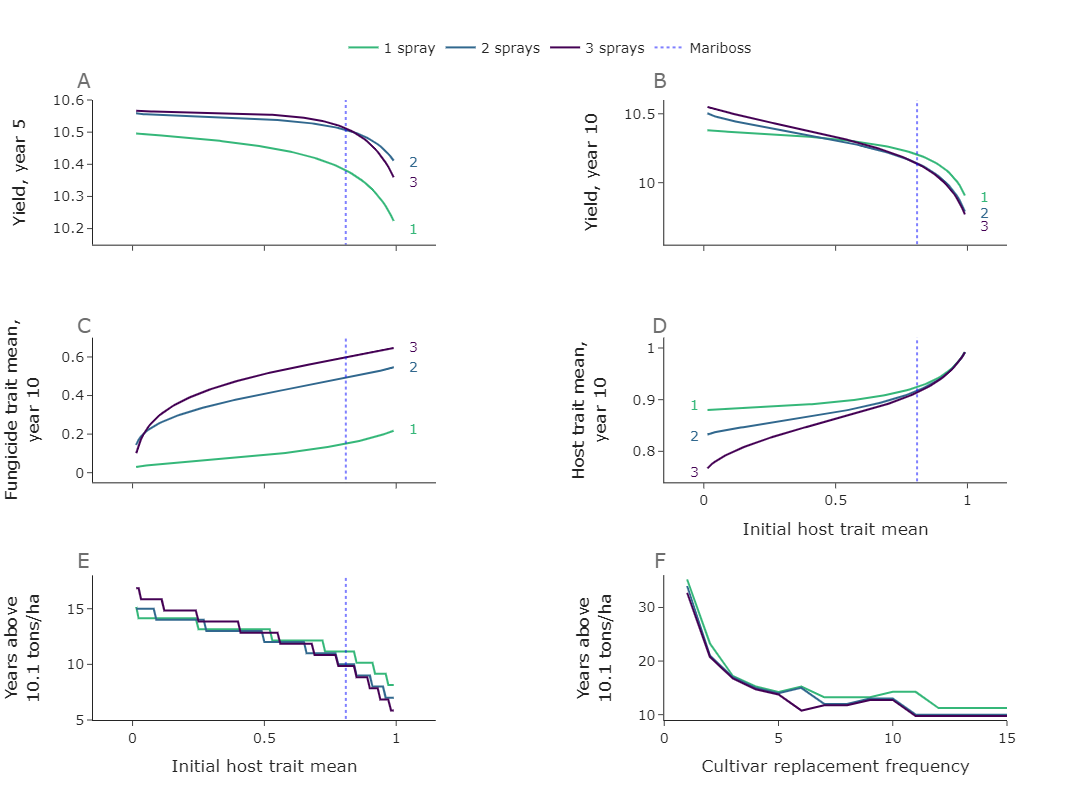

In [23]:
fig = mutual_figure(dfn_use, dfr_shifted)

fig.show()

In [24]:
fig.write_image('../figures/paper_figs/fig6_draft.png')

### Yield without fungicide

In [17]:
cs = Config(type='single', 
    sprays=[0], 
    host_on=[True],
    n_years=1,
    mutation_proportion=MUTATION_PROP,
    mutation_scale_fung=DEFAULT_P * FUNG_MUTATION_SCALE,
    mutation_scale_host=DEFAULT_P * HOST_MUTATION_SCALE
)

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078654159996959
host_on = [True]
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_iterations = None
n_k = 50
n_l = 50
n_years = 1
replace_cultivars = None
sprays = [0]
type = single



In [18]:
from polymodel.run import no_joblib_simulations_run

In [19]:
sol = no_joblib_simulations_run(cs)

running simulation


In [20]:
f"The yield without fungicide input is {sol['spray_N_host_Y']['yield_vec'][0]:.4f}"

'The yield without fungicide input is 9.9779'

In [ ]:
f, ax = plt.subplots()


for ii in range(25):
    yy = np.array(dfrp.iloc[ii].filter(like='fung_mean'))
    zz = np.array(dfrp.iloc[ii].filter(like='host_mean'))

    ax.plot(yy)
    ax.plot(zz)

## testing

### 1 is best?

In [ ]:
def max_by_spray(df):
    
    out = int(df.sort_values(by=['over_th1', 'sprays'], ascending=[False, True]).iloc[0].sprays)

    return out

In [ ]:
one_best_test = (
    dfn_use
    .loc[:, ['host_mean0', 'sprays', 'over_th1']]
    .groupby('host_mean0').apply(max_by_spray)
    .reset_index()
    .set_index('host_mean0')
)

one_best_test.plot()

In [ ]:
(
    one_best_test
    .reset_index()
    .sort_values([0, 'host_mean0'], ascending=[False, True])
    # .head(30)
)

In [ ]:
noisy = (
    dfn_use
    .assign(over_th_noise = lambda df: df.over_th1 + np.random.normal(0, 0.08, size=df.shape[0]))
)

f, ax = plt.subplots()

noisy.loc[lambda df: df.sprays==1, ['over_th_noise']].plot(ax=ax, c='r')
noisy.loc[lambda df: df.sprays==2, ['over_th_noise']].plot(ax=ax, c='g')
noisy.loc[lambda df: df.sprays==3, ['over_th_noise']].plot(ax=ax, c='b')

### Testing other stuff

In [ ]:
pd.DataFrame(
    dfr_use
    .loc[lambda df: df.repl_n==1]
    # .loc[lambda df: df.sprays==1]
    .filter(like='fung_mean')
    .T
).plot()

In [ ]:
dft = (
    dfn
    .apply(lambda df: years_above_threshold(df, 9.5), axis=1)
    .join(dfn)
)

dft.head(2)

Ok so think we want:

- th = 10, years above threshold
- th = 9.5, years above threshold

- years = 5, yield
- years = 10, yield

- fung mean year 10
- host mean year 10

- th = 10 years above threshold for replacing

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(8,8))

dft1 = dft.loc[lambda df: df.sprays==1]
dft2 = dft.loc[lambda df: df.sprays==2]
dft3 = dft.loc[lambda df: df.sprays==3]

ax[0].plot(dft1.host_mean0, dft1.over_th, label='1', c='r', lw=2)
ax[0].plot(dft2.host_mean0, dft2.over_th, label='2', c='b', lw=2)
ax[0].plot(dft3.host_mean0, dft3.over_th, label='3', c='k', lw=2)

ax[1].plot(dft1.host_mean0, dft1.over_th, label='1', c='r', lw=2)
ax[1].plot(dft2.host_mean0, dft2.over_th, label='2', c='b', lw=2)
ax[1].plot(dft3.host_mean0, dft3.over_th, label='3', c='k', lw=2)

ax[0].legend()

### repl testing

In [ ]:
f, ax = plt.subplots()

dfrp = dfr.loc[lambda df: df.sprays==1]

ax.plot(dfrp.repl_n, dfrp.host_mean49)

In [ ]:
f, ax = plt.subplots()

sns.scatterplot(x=dfrp.fung_mean49, y=dfrp.yld49, size=dfrp.host_mean49, alpha=0.5)

In [ ]:
dfrp.loc[lambda df: df.yld50<10, ['host_mean50', 'fung_mean50']].plot.scatter(x='host_mean50', y='fung_mean50')

In [ ]:
sns.scatterplot(
    x='fung_mean49',
    y='host_mean49',
    # size='yld50',
    size='repl_n',
    data=dfrp.loc[lambda df: df.yld50>9.7]
)